In [1]:
# 1. traditional backwards feature selection: take a feature out, retrain model without feature and see how performance changed. features who droppage least affects the
# model performance have love impact on predictive performance and should be permanently dropped
# 2. sensitivity analysis +backwards elimination feature selection. measuring how variance in each feature affects the output. THis method has different variants depending on the exact model
# (look into partial dependence plots)

In [2]:
%pip install ucimlrepo

###Loading the data set

In [3]:
from ucimlrepo import fetch_ucirepo
from ucimlrepo import list_available_datasets


# fetch dataset
wine_quality = fetch_ucirepo(id=186)


# data (as pandas dataframes)
X = wine_quality.data.features
y = wine_quality.data.targets



#X.head()
#y.head()
# variable information
#print(wine_quality.variables)

###Data Preprocessing: want to understand how the data is distributed and perfoming cleaning if necesary

<Axes: xlabel='quality'>

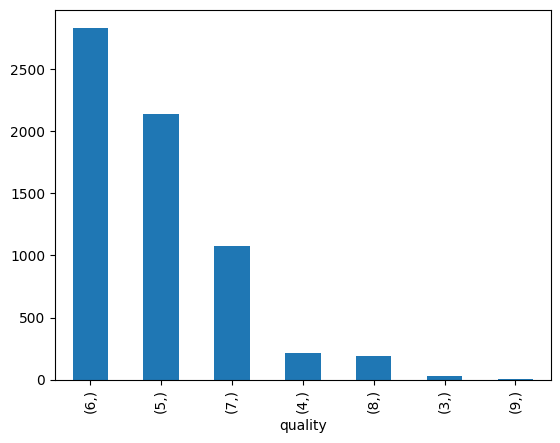

In [4]:
# histogram to give an idea of how imbalanced the quality is
#from matplotlib import pyplot as plt
#import seaborn as sns

y.value_counts().plot(kind='bar')

In [5]:
#X.describe()

#Model A (without sampling)



In [6]:
!pip install imbalanced-learn

###Split the data

In [7]:
from sklearn.model_selection import train_test_split
import pandas as pd

y_flat = y.values.ravel()
X_train, X_temp, y_train, y_temp = train_test_split(X,y_flat,train_size=0.7, random_state=17)
X_val, X_test, y_val, y_test = train_test_split(X_temp,y_temp,train_size=0.5, random_state=17)

best_models = []

###Check for imbalance in the training split

<Axes: xlabel='0'>

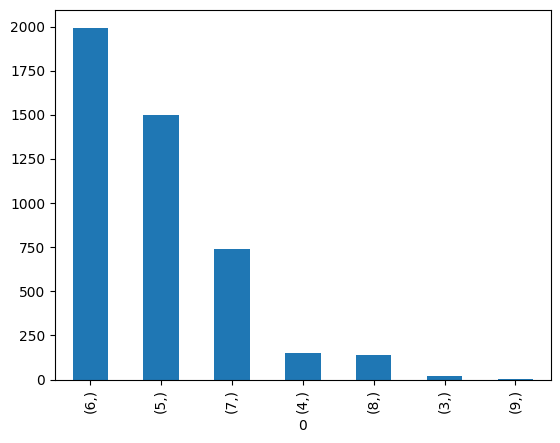

In [8]:
(pd.DataFrame(y_train)).value_counts().plot(kind='bar')

###I think its natural to have more normal wines that excellent ones so I would model with and without imbalance handling

In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)


##Modeling without class weighting

In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
import numpy as np

n_estimators_values = [ 150,300] # number of trees 100,300,400,500
max_feature_values = ['sqrt', 'log2', 3, 5]  # or 'sqrt', 'log2'
max_depths = [3, 5, 7]#[None, 10,15,20]           # None means no limit
min_samples_split = [2, 4, 8,25]
#max_feature_values = [1.0,2,5] #'sqrt','log2', 1.0,3,5,7,9,11
#max_depths = [ None,10] # None,20,30,50
#min_samples_split = [2,4,8] #2,16,64,128

RandomForest_results = []

# loop to combine every possible n_estimator, max_feature combination
for depth in max_depths:
  for split in min_samples_split:
    for n_estimator in n_estimators_values:
      for max_feature in max_feature_values:
        RandomForest_model = RandomForestClassifier(n_estimators= n_estimator, max_features= max_feature, max_depth=depth, min_samples_split=split, random_state=17)
        RandomForest_model.fit(X_train, y_train)

        #computing train performance
        RandomForest_y_train_pred = RandomForest_model.predict(X_train)

        #error computation
        T_RandomForest_accuracy = accuracy_score(y_train,  RandomForest_y_train_pred)
        T_RandomForest_precision = precision_score(y_train,  RandomForest_y_train_pred, average='weighted',zero_division=np.nan)
        T_RandomForest_recall = recall_score(y_train,  RandomForest_y_train_pred, average='weighted')
        T_RandomForest_f1 = f1_score(y_train,  RandomForest_y_train_pred, average='weighted')


        #computing val performance
        RandomForest_y_val_pred = RandomForest_model.predict(X_val)

        #error computation
        V_RandomForest_accuracy = accuracy_score(y_val,  RandomForest_y_val_pred)
        V_RandomForest_precision = precision_score(y_val,  RandomForest_y_val_pred, average='weighted',zero_division=np.nan)
        V_RandomForest_recall = recall_score(y_val,  RandomForest_y_val_pred, average='weighted')
        V_RandomForest_f1 = f1_score(y_val,  RandomForest_y_val_pred, average='weighted')

        RandomForest_results.append({
            'Type': 'pure_Non_FS',
            'T_accuracy' :  T_RandomForest_accuracy,
            'T_precision' :  T_RandomForest_precision,
            'T_recall' :  T_RandomForest_recall,
            'T_f1' :  T_RandomForest_f1,
            'n_estimators': n_estimator,
            'max_features':max_feature,
            'max_depth' : depth,
            'min_samples_split' : split,
            'V_accuracy' :  V_RandomForest_accuracy,
            'V_precision' :  V_RandomForest_precision,
            'V_recall' :  V_RandomForest_recall,
            'V_f1' :  V_RandomForest_f1
        })


RandomForest_result_df = pd.DataFrame(RandomForest_results)

RandomForest_result_df.sort_values(by='V_accuracy', ascending=False, inplace=True)
RandomForest_result_df.reset_index(drop=True, inplace=True)

best_RandomForest = RandomForest_result_df.iloc[0].to_dict()
best_models.append(best_RandomForest)

print(f'Best RandomForest {best_RandomForest}')

RandomForest_result_df

Best RandomForest {'Type': 'pure_Non_FS', 'T_accuracy': 0.6668132834836156, 'T_precision': 0.701034834520299, 'T_recall': 0.6668132834836156, 'T_f1': 0.6426137576682227, 'n_estimators': 300, 'max_features': 5, 'max_depth': 7, 'min_samples_split': 8, 'V_accuracy': 0.5856410256410256, 'V_precision': 0.6159805010077437, 'V_recall': 0.5856410256410256, 'V_f1': 0.5492727656898424}


,Type,T_accuracy,T_precision,T_recall,T_f1,n_estimators,max_features,max_depth,min_samples_split,V_accuracy,V_precision,V_recall,V_f1
0,pure_Non_FS,0.666813,0.701035,0.666813,0.642614,300,5,7,8,0.585641,0.615981,0.585641,0.549273
1,pure_Non_FS,0.666373,0.700911,0.666373,0.642360,150,5,7,4,0.584615,0.608729,0.584615,0.548965
2,pure_Non_FS,0.665054,0.699605,0.665054,0.640544,150,5,7,8,0.584615,0.610452,0.584615,0.549294
3,pure_Non_FS,0.669452,0.704142,0.669452,0.645096,300,5,7,4,0.583590,0.609384,0.583590,0.548028
4,pure_Non_FS,0.673631,0.705866,0.673631,0.651575,150,5,7,2,0.582564,0.608296,0.582564,0.546977
...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,pure_Non_FS,0.555531,0.618094,0.555531,0.489878,150,sqrt,3,2,0.529231,0.519863,0.529231,0.461240
92,pure_Non_FS,0.555531,0.618094,0.555531,0.489878,150,sqrt,3,8,0.529231,0.519863,0.529231,0.461240
93,pure_Non_FS,0.555531,0.618094,0.555531,0.489878,150,3,3,8,0.529231,0.519863,0.529231,0.461240
94,pure_Non_FS,0.555531,0.618094,0.555531,0.489878,150,sqrt,3,4,0.529231,0.519863,0.529231,0.461240


##Modeling with class weighting

In [11]:
from imblearn.ensemble import BalancedRandomForestClassifier

brf_results = []

n_estimators_values = [ 150,160,300, 96] # number of trees 100,300,400,500
max_feature_values = [2,1.0,'sqrt','log2'] #'sqrt','log2', 1.0,3,5,7,9,11
max_depths = [ None] # None,20,30,50
min_samples_split = [2,6,8,12,24] #2,16,64,128



# loop to combine every possible n_estimator, max_feature combination
for depth in max_depths:
  for split in min_samples_split:
    for n_estimator in n_estimators_values:
      for max_feature in max_feature_values:

        brf = BalancedRandomForestClassifier(
            n_estimators= n_estimator, max_features= max_feature, max_depth=depth, min_samples_split=split,
            random_state=17,  sampling_strategy="all", replacement=True,
            bootstrap=False
        )

        brf.fit(X_train, y_train)

        #training peformance
        brf_y_train_pred = brf.predict(X_train)

        T_brf_accuracy = accuracy_score(y_train,  brf_y_train_pred)
        T_brf_precision = precision_score(y_train,  brf_y_train_pred, average='weighted',zero_division=np.nan)
        T_brf_recall = recall_score(y_train,  brf_y_train_pred, average='weighted')
        T_brf_f1 = f1_score(y_train,  brf_y_train_pred, average='weighted')


        #validation performance
        brf_y_val_pred = brf.predict(X_val)

        #error computation
        V_brf_accuracy = accuracy_score(y_val,  brf_y_val_pred)
        V_brf_precision = precision_score(y_val,  brf_y_val_pred, average='weighted',zero_division=np.nan)
        V_brf_recall = recall_score(y_val,  brf_y_val_pred, average='weighted')
        V_brf_f1 = f1_score(y_val,  brf_y_val_pred, average='weighted')

        brf_results.append({
            'Type': 'brf_Non_FS',
            'T_accuracy' :  T_brf_accuracy,
            'T_precision' :  T_brf_precision,
            'T_recall' :  T_brf_recall,
            'T_f1' :  T_brf_f1,
            'n_estimators': n_estimator,
            'max_features':max_feature,
            'max_depth' : depth,
            'min_samples_split' : split,
            'V_accuracy' :  V_brf_accuracy,
            'V_precision' :  V_brf_precision,
            'V_recall' :  V_brf_recall,
            'V_f1' :  V_brf_f1
        })

brf_result_df = pd.DataFrame(brf_results)

brf_result_df.sort_values(by='V_accuracy', ascending=False, inplace=True)
brf_result_df.reset_index(drop=True, inplace=True)

best_brf = brf_result_df.iloc[0].to_dict()
best_models.append(best_brf)

print(f'Best brf {best_brf}')

brf_result_df


Best brf {'Type': 'brf_Non_FS', 'T_accuracy': 0.38223004178579284, 'T_precision': 0.4919759274707551, 'T_recall': 0.38223004178579284, 'T_f1': 0.39822807263560817, 'n_estimators': 150, 'max_features': 'sqrt', 'max_depth': None, 'min_samples_split': 8, 'V_accuracy': 0.3682051282051282, 'V_precision': 0.4624976200023303, 'V_recall': 0.3682051282051282, 'V_f1': 0.383304253801301}


,Type,T_accuracy,T_precision,T_recall,T_f1,n_estimators,max_features,max_depth,min_samples_split,V_accuracy,V_precision,V_recall,V_f1
0,brf_Non_FS,0.382230,0.491976,0.382230,0.398228,150,sqrt,None,8,0.368205,0.462498,0.368205,0.383304
1,brf_Non_FS,0.382230,0.491976,0.382230,0.398228,150,log2,None,8,0.368205,0.462498,0.368205,0.383304
2,brf_Non_FS,0.376292,0.485754,0.376292,0.393767,160,sqrt,None,8,0.362051,0.458209,0.362051,0.377177
3,brf_Non_FS,0.376292,0.485754,0.376292,0.393767,160,log2,None,8,0.362051,0.458209,0.362051,0.377177
4,brf_Non_FS,0.375632,0.498029,0.375632,0.391355,96,log2,None,8,0.355897,0.462944,0.355897,0.372745
5,brf_Non_FS,0.375632,0.498029,0.375632,0.391355,96,sqrt,None,8,0.355897,0.462944,0.355897,0.372745
6,brf_Non_FS,0.370354,0.491294,0.370354,0.396445,150,log2,None,12,0.354872,0.460421,0.354872,0.381055
7,brf_Non_FS,0.373213,0.487567,0.373213,0.410535,96,2,None,8,0.354872,0.454367,0.354872,0.386792
8,brf_Non_FS,0.386409,0.497072,0.386409,0.415183,150,2,None,6,0.354872,0.449920,0.354872,0.379821
9,brf_Non_FS,0.370354,0.491294,0.370354,0.396445,150,sqrt,None,12,0.354872,0.460421,0.354872,0.381055


#Modeling with SMOTE

In [12]:
#We are resplitting the data because we have already performing scaling in the experiments above
X_train, X_temp, y_train, y_temp = train_test_split(X,y_flat,train_size=0.7, random_state=17)
X_val, X_test, y_val, y_test = train_test_split(X_temp,y_temp,train_size=0.5, random_state=17)

In [13]:
# counting the number of classes in train
#from collections import Counter
#print (Counter(y_train))

In [14]:
#handling imbalance
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=17,k_neighbors=2)
# prefixing with s to indicate smote
sX_train, sy_train = smote.fit_resample(X_train, y_train)

In [15]:
# scaling
scaler = StandardScaler()
sX_train = scaler.fit_transform(sX_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)


In [16]:
n_estimators_values = [ 150,300] # number of trees 100,300,400,500
max_feature_values = [1.0,2,5] #'sqrt','log2', 1.0,3,5,7,9,11
max_depths = [ None,10] # None,20,30,50
min_samples_split = [2,4,8] #2,16,64,128

RandomForest_results = []

# loop to combine every possible n_estimator, max_feature combination
for depth in max_depths:
  for split in min_samples_split:
    for n_estimator in n_estimators_values:
      for max_feature in max_feature_values:
        RandomForest_model = RandomForestClassifier(n_estimators= n_estimator, max_features= max_feature, max_depth=depth, min_samples_split=split, random_state=17)
        RandomForest_model.fit(sX_train, sy_train)

        #computing train performance
        RandomForest_y_train_pred = RandomForest_model.predict(sX_train)

        #error computation
        T_RandomForest_accuracy = accuracy_score(sy_train,  RandomForest_y_train_pred)
        T_RandomForest_precision = precision_score(sy_train,  RandomForest_y_train_pred, average='weighted',zero_division=np.nan)
        T_RandomForest_recall = recall_score(sy_train,  RandomForest_y_train_pred, average='weighted')
        T_RandomForest_f1 = f1_score(sy_train,  RandomForest_y_train_pred, average='weighted')


        #computing val performance
        RandomForest_y_val_pred = RandomForest_model.predict(X_val)

        #error computation
        V_RandomForest_accuracy = accuracy_score(y_val,  RandomForest_y_val_pred)
        V_RandomForest_precision = precision_score(y_val,  RandomForest_y_val_pred, average='weighted',zero_division=np.nan)
        V_RandomForest_recall = recall_score(y_val,  RandomForest_y_val_pred, average='weighted')
        V_RandomForest_f1 = f1_score(y_val,  RandomForest_y_val_pred, average='weighted')

        RandomForest_results.append({
            'Type': 'smote_Non_FS',
            'T_accuracy' :  T_RandomForest_accuracy,
            'T_precision' :  T_RandomForest_precision,
            'T_recall' :  T_RandomForest_recall,
            'T_f1' :  T_RandomForest_f1,
            'n_estimators': n_estimator,
            'max_features':max_feature,
            'max_depth' : depth,
            'min_samples_split' : split,
            'V_accuracy' :  V_RandomForest_accuracy,
            'V_precision' :  V_RandomForest_precision,
            'V_recall' :  V_RandomForest_recall,
            'V_f1' :  V_RandomForest_f1
        })


RandomForest_result_df = pd.DataFrame(RandomForest_results)

RandomForest_result_df.sort_values(by='V_accuracy', ascending=False, inplace=True)
RandomForest_result_df.reset_index(drop=True, inplace=True)

best_RandomForest = RandomForest_result_df.iloc[0].to_dict()
best_models.append(best_RandomForest)

print(f'Best RandomForest {best_RandomForest}')

RandomForest_result_df

Best RandomForest {'Type': 'smote_Non_FS', 'T_accuracy': 1.0, 'T_precision': 1.0, 'T_recall': 1.0, 'T_f1': 1.0, 'n_estimators': 300, 'max_features': 5.0, 'max_depth': nan, 'min_samples_split': 4, 'V_accuracy': 0.6369230769230769, 'V_precision': 0.6403018589244741, 'V_recall': 0.6369230769230769, 'V_f1': 0.6358320929174586}


,Type,T_accuracy,T_precision,T_recall,T_f1,n_estimators,max_features,max_depth,min_samples_split,V_accuracy,V_precision,V_recall,V_f1
0,smote_Non_FS,1.000000,1.000000,1.000000,1.000000,300,5.0,NaN,4,0.636923,0.640302,0.636923,0.635832
1,smote_Non_FS,1.000000,1.000000,1.000000,1.000000,150,5.0,NaN,4,0.633846,0.636967,0.633846,0.632653
2,smote_Non_FS,0.996776,0.996774,0.996776,0.996774,150,5.0,NaN,8,0.633846,0.638211,0.633846,0.633212
3,smote_Non_FS,1.000000,1.000000,1.000000,1.000000,150,2.0,NaN,4,0.632821,0.637757,0.632821,0.631873
4,smote_Non_FS,0.996848,0.996847,0.996848,0.996846,300,5.0,NaN,8,0.632821,0.638369,0.632821,0.632455
5,smote_Non_FS,1.000000,1.000000,1.000000,1.000000,300,2.0,NaN,4,0.631795,0.637991,0.631795,0.631053
6,smote_Non_FS,1.000000,1.000000,1.000000,1.000000,300,2.0,NaN,2,0.630769,0.633012,0.630769,0.628794
7,smote_Non_FS,1.000000,1.000000,1.000000,1.000000,150,2.0,NaN,2,0.628718,0.631986,0.628718,0.627345
8,smote_Non_FS,1.000000,1.000000,1.000000,1.000000,300,5.0,NaN,2,0.624615,0.630839,0.624615,0.624656
9,smote_Non_FS,1.000000,1.000000,1.000000,1.000000,150,5.0,NaN,2,0.620513,0.623211,0.620513,0.620811


#Choosing a the best model for feature selection



In [17]:
#analyzing the top models in every experiment above to pick the best one
best_models_df = pd.DataFrame(best_models)
#best_models_df.drop( columns=['Type', 'accuracy', 'precision', 'recall', 'f1'], inplace=True)

chosen_one = best_models_df.iloc[0]
chosen_one =chosen_one[['n_estimators', 'max_features', 'max_depth', 'min_samples_split']].to_dict()
chosen_one['max_depth'] = int(chosen_one['max_depth'] )
print(chosen_one)
best_models_df


{'n_estimators': 300, 'max_features': 5, 'max_depth': 7, 'min_samples_split': 8}


,Type,T_accuracy,T_precision,T_recall,T_f1,n_estimators,max_features,max_depth,min_samples_split,V_accuracy,V_precision,V_recall,V_f1
0,pure_Non_FS,0.666813,0.701035,0.666813,0.642614,300,5,7.0,8,0.585641,0.615981,0.585641,0.549273
1,brf_Non_FS,0.382230,0.491976,0.382230,0.398228,150,sqrt,NaN,8,0.368205,0.462498,0.368205,0.383304
2,smote_Non_FS,1.000000,1.000000,1.000000,1.000000,300,5.0,NaN,4,0.636923,0.640302,0.636923,0.635832


#Feature Selection

In [18]:
from sklearn.inspection import permutation_importance

#resplitting the data
X_train, X_temp, y_train, y_temp = train_test_split(X,y_flat,train_size=0.7, random_state=17)
X_val, X_test, y_val, y_test = train_test_split(X_temp,y_temp,train_size=0.5, random_state=17)

# have t make sure we feed the same data structures to the model
'''y_test = pd.DataFrame(y_test)
y_train = pd.DataFrame(y_train)
y_val =   pd.DataFrame(y_val)'''

#rescaling
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_val = pd.DataFrame(scaler.transform(X_val),columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test),columns=X.columns)


#declaring the chosen estimator and passing in best parameters
FS_model = RandomForestClassifier(**chosen_one,  random_state=17)
FS_model.fit(X_train,y_train)

result = permutation_importance( FS_model,X_val,y_val,scoring='f1_macro', n_repeats=5,random_state=17)

importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance_mean': result.importances_mean,
    'importance_std': result.importances_std
}).sort_values(by='importance_mean', ascending=False)


importances


,feature,importance_mean,importance_std
10,alcohol,0.081769,0.008922
1,volatile_acidity,0.034029,0.004461
4,chlorides,0.030912,0.006918
7,density,0.028358,0.001433
5,free_sulfur_dioxide,0.017412,0.002690
3,residual_sugar,0.015903,0.004096
6,total_sulfur_dioxide,0.014223,0.003868
9,sulphates,0.010288,0.002084
8,pH,0.009727,0.005250
2,citric_acid,0.006434,0.001068


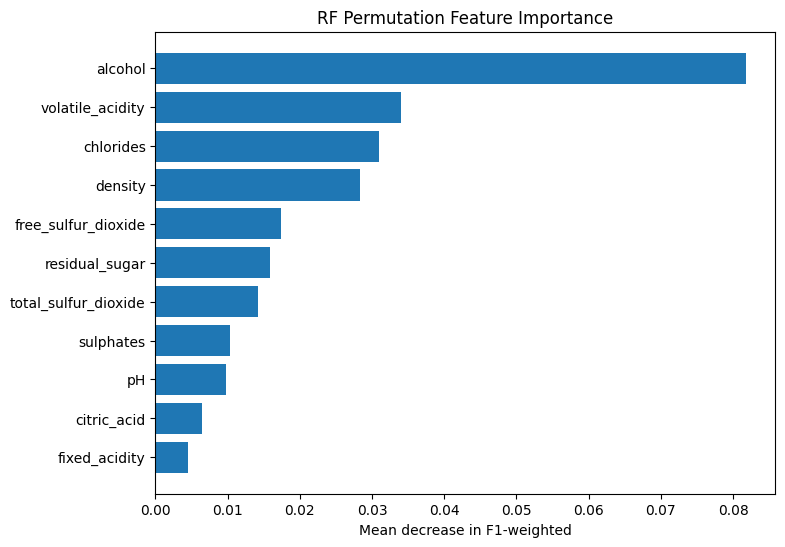

In [19]:
#experimental plotting
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.barh(importances['feature'], importances['importance_mean'])
plt.gca().invert_yaxis()
plt.title("RF Permutation Feature Importance")
plt.xlabel("Mean decrease in F1-weighted")
plt.show()

In [20]:
# threshold for feature droppage
drop_thres = 0.01

selected_features = importances[importances['importance_mean'] > drop_thres]['feature']


FS_X_train = X_train[selected_features]
FS_X_val = X_val[selected_features]
FS_X_test = X_test[selected_features]
print('Selected features: ', selected_features )

Selected features:  10                 alcohol
1         volatile_acidity
4                chlorides
7                  density
5      free_sulfur_dioxide
3           residual_sugar
6     total_sulfur_dioxide
9                sulphates
Name: feature, dtype: object


# Fitting Final Model and Performing Evaluation

In [22]:
Final_Model = RandomForestClassifier(**chosen_one, random_state= 17)
Final_Model.fit(FS_X_train, y_train)

# make predictions on test
y_test_pred = Final_Model.predict(FS_X_test)

# compute metrics for test
accuracy = accuracy_score(y_test, y_test_pred)
macro_precision = precision_score(y_test, y_test_pred, average='macro',zero_division=np.nan)
macro_recall = recall_score(y_test, y_test_pred, average='macro')
macro_f1 = f1_score(y_test, y_test_pred, average='macro')
weighted_precision = precision_score(y_test, y_test_pred, average='weighted',zero_division=np.nan)
weighted_recall = recall_score(y_test, y_test_pred, average='weighted')
weighted_f1 = f1_score(y_test, y_test_pred, average='weighted')


eval_stats = {'Type': 'Random Forest',
      'accuracy' : accuracy,
      'macro_precision' : macro_precision,
      'weighted_precision' : weighted_precision,
      'macro_recall' : macro_recall,
      'weighted_recall' : weighted_recall,
      'macro_f1' : macro_f1,
      'weighted_f1' : weighted_f1,
      **chosen_one
}


print (eval_stats)

{'Type': 'Random Forest', 'accuracy': 0.5641025641025641, 'macro_precision': 0.6782376162401642, 'weighted_precision': 0.5825838573441754, 'macro_recall': 0.23603665147830408, 'weighted_recall': 0.5641025641025641, 'macro_f1': 0.2384146819696425, 'weighted_f1': 0.5335833975778755, 'n_estimators': 300, 'max_features': 5, 'max_depth': 7, 'min_samples_split': 8}
